# ex08-Watershed Delineation from DEM

Digital elevation models (DEMs) are often used for watershed delineation and data extracted from the delineated watershed relevant required by distributed hydrological models. 

A watershed is the upslope area that contributes flow—generally water—to a common outlet as concentrated drainage. It can be part of a larger watershed and can also contain smaller watersheds, called subbasins. The boundaries between watersheds are termed drainage divides. The outlet, or pour point, is the point on the surface at which water flows out of an area. It is the lowest point along the boundary of a watershed. A Watershed can be delineated from a digital elevation model (DEM) by computing the flow direction.

This notebook will show you how to delineate Watersheds from a Digital Elevation Model (DEM) based on the python package of pysheds. [Pysheds](https://www.hatarilabs.com/ih-en/elevation-model-conditioning-and-stream-network-delimitation-with-python-and-pysheds-tutorial) is a Python 3 package designed for watershed delimitation and stream network extraction. This library requires a set of advanced data processing and spatial analysis libraries as Numpy, Pandas, Scipy, Scikit-Image, Rasterio and others. 

The latest version of Pysheds allows the use of digital elevation models in both geograpical coordinates (WGS84 as in this notebook) and projected coordinates (WGS 84 UTM). This feature increase the versatility of the hydrological analysis. In addition, Pysheds provides many excellent tutorials. You can check the [link](https://mattbartos.com/pysheds/extract-river-network.html) for more details.

In [1]:
%matplotlib inline

import numpy as np
from pysheds.grid import Grid
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Open DEM data

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
grid = Grid.from_raster('data/n30w100_con', data_name='dem')

## Preprocess

It is important to use a DEM with no ***depressions*** or ***sinks***. A sink is a cell that does not have an associated drainage value. Drainage values indicate the direction that water will flow out of the cell, and are assigned during the process of creating a flow direction grid for the landscape. The resulting drainage network depends on finding the ‘flow path’ of every cell in the grid, so it is important that the fill step is performed prior to creating a flow direction grid.

Two preprocessing tasks include:
- Detect and fill depressions
- Detect and resolve flats

In [3]:
grid.fill_depressions(data='dem', out_name='flooded_dem')

grid.resolve_flats('flooded_dem', out_name='inflated_dem')

## Compute flow directions

A flow direction grid assigns a value to each cell to indicate the direction of flow – that is, the direction that water will flow from that particular cell based on the underlying topography of the landscape. This is a crucial step in hydrological modeling, as the direction of flow will determine the ultimate destination of the water flowing across the surface of the land.

By default, pysheds will compute flow directions using the ***D8 routing scheme***. In this routing mode, each cell is routed to one of eight neighboring cells based on the direction of steepest descent.

***Directional mappings***

Cardinal and intercardinal directions are represented by numeric values in the output grid. By default, the ESRI scheme is used:

- North: 64
- Northeast: 128
- East: 1
- Southeast: 2
- South: 4
- Southwest: 8
- West: 16
- Northwest: 32

In [5]:
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
boundaries = ([0] + sorted(list(dirmap)))

## Delineate catchment

To delineate a catchment, first specify a ***pour point*** (the ***outlet*** of the catchment). Pour point placement is an important step in the process of watershed delineation. A pour point should exist within an area of high flow accumulation because it is used to calculate the total contributing water flow to that given point. In many cases, you could already know where the locations of your pour points are. If the x and y components of the pour point are spatial coordinates in the grid’s spatial reference system, specify xytype='label'.

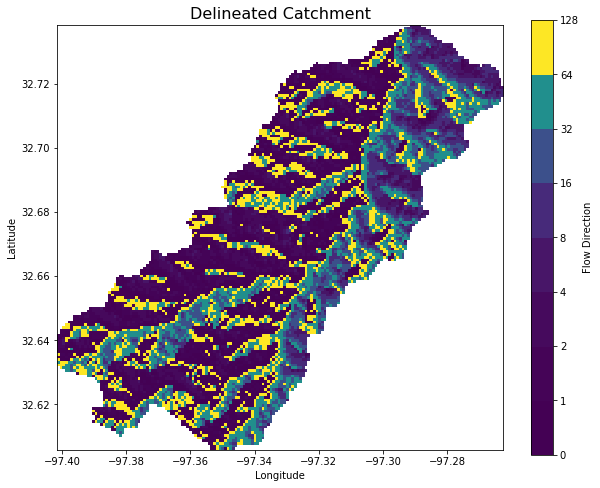

In [18]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Clip the bounding box to the catchment
grid.clip_to('catch')

# Get a view of the catchment
catch = grid.view('catch', nodata=np.nan)

# Plot the catchment
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
_= ax.set_xlabel('Longitude')
_= ax.set_ylabel('Latitude')
_= ax.set_title('Delineated Catchment', fontsize=16)

## Get flow accumulation

The Flow Accumulation tool calculates the flow into each cell by identifying the upstream cells that flow into each downslope cell. In other words, each cell’s flow accumulation value is determined by the number of upstream cells flowing into it based on landscape topography.

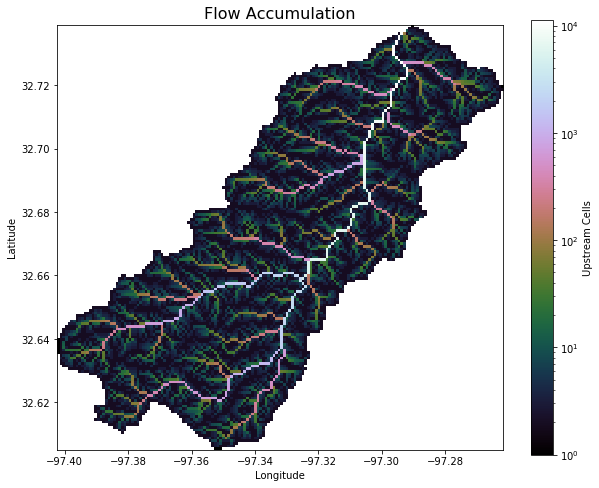

In [17]:
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
_= ax.set_xlabel('Longitude')
_= ax.set_ylabel('Latitude')
_= ax.set_title('Flow Accumulation', fontsize=16)

## Get distances to upstream cells

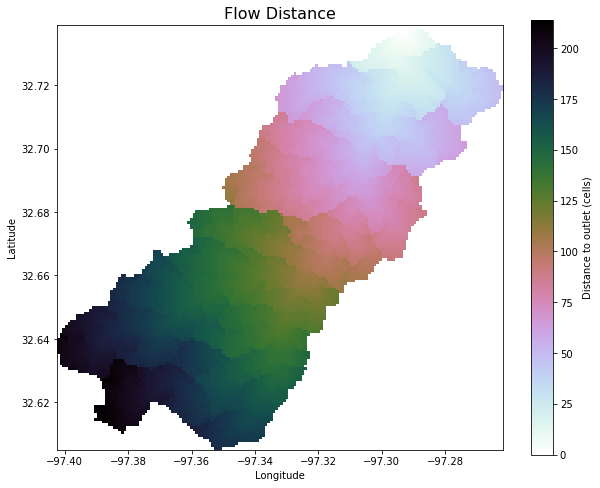

In [15]:
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
_= ax.set_xlabel('Longitude')
_= ax.set_ylabel('Latitude')
_= ax.set_title('Flow Distance', fontsize=16)

## Extracting the river network

To extract the river network at a given accumulation threshold, we can call the grid.extract_river_network method. By default, the method will use an accumulation threshold of 100 cells:

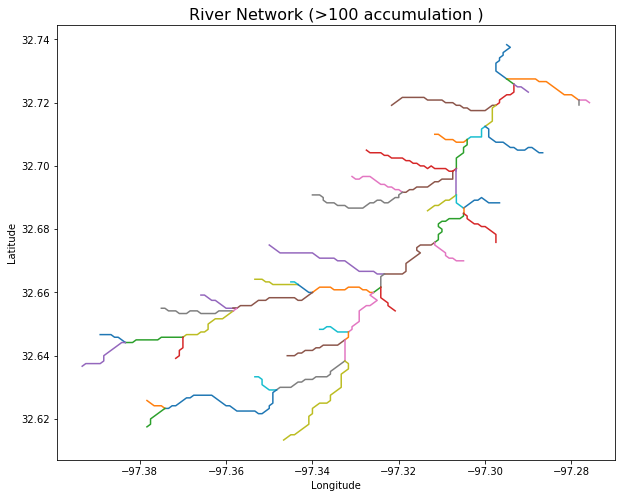

In [22]:
branches = grid.extract_river_network('catch', 'acc')

fig, ax = plt.subplots(figsize=(10, 8))
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    ax.plot(line[:, 0], line[:, 1])
    
_= ax.set_xlabel('Longitude')
_= ax.set_ylabel('Latitude')
_= ax.set_title('River Network (>100 accumulation )', fontsize=16)

***Specifying the accumulation threshold***

We can change the geometry of the returned river network by specifying different accumulation thresholds. For example, we set threshold=5. However, smaller thresholds will produce too many branches that could be over details.

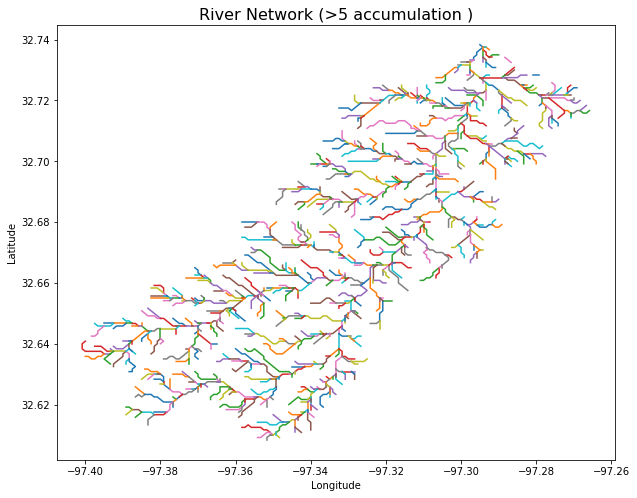

In [24]:
branches_5 = grid.extract_river_network('catch', 'acc', threshold=5)

fig, ax = plt.subplots(figsize=(10, 8))
for branch in branches_5['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    ax.plot(line[:, 0], line[:, 1])
    
_= ax.set_xlabel('Longitude')
_= ax.set_ylabel('Latitude')
_= ax.set_title('River Network (>5 accumulation )', fontsize=16)

## References

Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

https://seaborn.pydata.org/introduction.html

https://www.hatarilabs.com/ih-en/elevation-model-conditioning-and-stream-network-delimitation-with-python-and-pysheds-tutorial